In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [10]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [3]:
#!unzip -qq /content/drive/'My Drive'/Code/tomatoes.zip

In [4]:
dataset_path = '/content/PlantVillage'

class_name = []
images = []
labels = []
for index, folder in enumerate(os.listdir(dataset_path)):
  class_name.append(folder)
  image_path = os.path.join(dataset_path, folder)
  # print(image_path, len(os.listdir(image_path)))
  for image in os.listdir(image_path):
    labels.append(index)
    images.append(os.path.join(dataset_path, folder, image))

X = []
for index, path in enumerate(tqdm(images)):
  try:
    X.append(cv2.resize(cv2.imread(path),dsize=(256,256)))
  except:
    labels.pop(index)
X = np.array(X)
y = np.array(labels)
Y = to_categorical(y, num_classes=len(class_name))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,stratify = Y, shuffle=True, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify = y_test, shuffle=True, random_state=100)
print(X_train.shape, X_test.shape,X_val.shape)
print(y_train.shape, y_test.shape,y_val.shape)

(8664, 256, 256, 3) (1857, 256, 256, 3) (1857, 256, 256, 3)
(8664, 5) (1857, 5) (1857, 5)


In [6]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.1,
    rescale=1./255,
	width_shift_range=0.1,
    height_shift_range=0.1,
	horizontal_flip=True,
    brightness_range=[0.2,1.5], fill_mode="nearest")

In [7]:
model = Sequential()
inputShape = (256, 256, 3)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (256, 256, 3)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation("softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)        0

In [11]:
filepath="/content/weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
opt = Adam(lr=(1e-3), decay=(1e-3) / 25)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("[INFO] training network...")
history = model.fit(
    aug.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // 64,
    epochs=40, verbose=1, callbacks=callbacks_list
    )

[INFO] training network...
Epoch 1/40
135/135 [==============================] - ETA: 0s - loss: 0.3441 - accuracy: 0.6751
Epoch 00001: val_accuracy improved from -inf to 0.24663, saving model to /content/weights-01-0.25.hdf5
135/135 [==============================] - 143s 1s/step - loss: 0.3441 - accuracy: 0.6751 - val_loss: 4.4442 - val_accuracy: 0.2466
Epoch 2/40
135/135 [==============================] - ETA: 0s - loss: 0.1921 - accuracy: 0.8234
Epoch 00002: val_accuracy improved from 0.24663 to 0.33818, saving model to /content/weights-02-0.34.hdf5
135/135 [==============================] - 142s 1s/step - loss: 0.1921 - accuracy: 0.8234 - val_loss: 3.9820 - val_accuracy: 0.3382
Epoch 3/40
135/135 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.8723
Epoch 00003: val_accuracy improved from 0.33818 to 0.51373, saving model to /content/weights-03-0.51.hdf5
135/135 [==============================] - 141s 1s/step - loss: 0.1297 - accuracy: 0.8723 - val_loss: 2.80

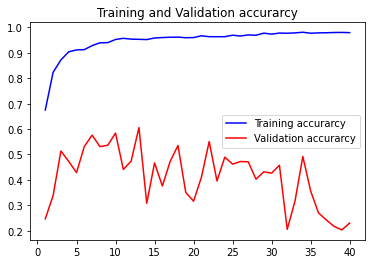

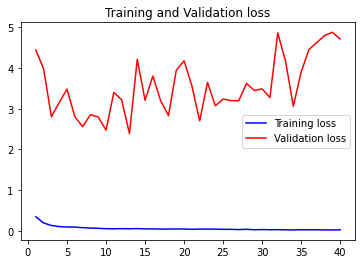

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [16]:
print("[INFO] Calculating model accuracy")
from keras.models import load_model
model = load_model('/content/weights-10-0.58.hdf5')
scores = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
59/59 [==============================] - 1s 14ms/step - loss: 2.4829 - accuracy: 0.5827
Test Accuracy: 58.26601982116699


In [15]:
model.save("customCNN.h5")

AttributeError: ignored